In [1]:
import pandas as pd
import numpy as np
import xgboost as xg
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, CatBoostRegressor, cv, Pool

In [2]:
data_path = "data/"
dataset_train = pd.read_csv(data_path + "train.csv")

dataset_train

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1
...,...,...,...,...,...,...
7377413,6xdFzPlrasIDD95mQWXVC3Bg4ptnGYtBl4ztVEZMddU=,VJTxizih/o28kXCbtPbIyWXScoXGvxyYtl6R+0YB5JM=,my library,Local playlist more,local-playlist,1
7377414,ZxbVmt3Kh/XOH+h58c2Kdj6SjFZk+wnUO006IgWzMQE=,z1mqaU9YOX7T/PFDvUoWozdFq7rC3KwaQP7nFVprjMI=,search,Search,song,0
7377415,ZxbVmt3Kh/XOH+h58c2Kdj6SjFZk+wnUO006IgWzMQE=,750RprmFfLV0bymtDH88g24pLZGVi5VpBAI300P6UOA=,search,Search,song,1
7377416,0aH4Hd3ziPSRHClRX8rkeOEaAG5EPPkW1mKGCdXEok0=,G8wgqObgeAMER/rVCIlgcNeQ8mm0CzF/GsxiMK8TTnA=,discover,Discover Genre,online-playlist,1


In [3]:
dataset_train.isnull().sum(axis=0)

msno                       0
song_id                    0
source_system_tab      24849
source_screen_name    414804
source_type            21539
target                     0
dtype: int64

In [4]:
dataset_train['source_system_tab'] = dataset_train['source_system_tab'].fillna('unknown')
dataset_train['source_screen_name'] = dataset_train['source_screen_name'].fillna('unknown')
dataset_train['source_type'] = dataset_train['source_type'].fillna('unknown')

In [5]:
dataset_members = pd.read_csv(data_path + "members.csv")
dataset_members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


Проверим, что в тренировочном датасете отсутсвуют неизвестные пользователи, то есть пользователи которых нет в members.csv

In [6]:
len(set(dataset_train['msno']) - set(dataset_members['msno']))

0

In [7]:
dataset_members.isnull().sum(axis=0)

msno                          0
city                          0
bd                            0
gender                    19902
registered_via                0
registration_init_time        0
expiration_date               0
dtype: int64

In [8]:
dataset_members['gender'] = dataset_members['gender'].fillna('unknown')

In [9]:
dataset_members.dtypes

msno                      object
city                       int64
bd                         int64
gender                    object
registered_via             int64
registration_init_time     int64
expiration_date            int64
dtype: object

Поменяем важные численные признаки, которые принимают всего по несколько значений, на категориальные

In [10]:
dataset_members['city'] = dataset_members['city'].astype(str)
dataset_members['registered_via'] = dataset_members['registered_via'].astype(str)

In [11]:
dataset_members['bd'].describe()

count    34403.000000
mean        12.280935
std         18.170251
min        -43.000000
25%          0.000000
50%          0.000000
75%         25.000000
max       1051.000000
Name: bd, dtype: float64

Возраст имеет огромные выбросы от -43 до 1051, а также огромное количество нулей.
Будем считать значение выбросом если оно меньше 7 лет или больше 80.
Вместо всех таких выбросов напишем 0, чтобы потом классифицировать их в возрастную группу unknown.

In [12]:
dataset_members['bd'] = dataset_members['bd'].apply(lambda x: 0 if x < 7 or x > 80 else x)

age_separators = [-1, 7, 18, 23, 35, 50, np.inf]
names = ['unknown', '7-18', '18-23', '23-35', '35-50', '50plus']
dataset_members['age_group'] = pd.cut(dataset_members['bd'], age_separators, labels=names)
dataset_members['age_group'].value_counts()

unknown    19972
23-35       7033
18-23       3286
35-50       2472
7-18        1226
50plus       414
Name: age_group, dtype: int64

Выкинем уже ненужные признаки и обьединим dataset_members c общим датасетом.

In [13]:
dataset_members.drop(['bd', 'registration_init_time', 'expiration_date'], axis=1, inplace=True)
dataset_train = dataset_train.merge(dataset_members, on='msno', how='left')

In [14]:
dataset_songs = pd.read_csv(data_path + "songs.csv")
dataset_songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [15]:
dataset_songs.isnull().sum(axis=0)

song_id              0
song_length          0
genre_ids        94116
artist_name          0
composer       1071354
lyricist       1945268
language             1
dtype: int64

Для пропущенных жанров введем значение unknown, а также если в качестве жанра подано сразу несколько чере '|' то будем брать первый.

In [16]:
def cleane_genre(genre):
    pos_separator = genre.find('|')
    return genre if pos_separator == -1 else genre[:pos_separator]

dataset_songs['genre_ids'].fillna('unknown', inplace=True)
dataset_songs['genre_ids'] = dataset_songs['genre_ids'].apply(cleane_genre)

Будем считать корректную длину песни от 30 секунд до 20 минут, остальные значения заменим медианой

In [17]:
valid_length = np.logical_and(dataset_songs.song_length >= 0.5 * 60 * 1e3,
                              dataset_songs.song_length <= 20 * 60 * 1e3)
length_median = np.median(dataset_songs[valid_length].song_length)
dataset_songs.loc[~valid_length, 'song_length'] = length_median

In [18]:
most_frequent_lang = dataset_songs['language'].mode()[0]
dataset_songs['language'] = dataset_songs['language'].fillna(int(most_frequent_lang)).astype(str)

Аналогично, как и с пользователями - проверим, что в общем датасете отсутсвуют неизвестные песни, то есть песни которых нет в songs.csv.
Оказалось есть совсем немного таких песен, заполним их дефолтными значениями.

In [19]:
missing_song_ids = set(dataset_train['song_id']) - set(dataset_songs['song_id'])
len(missing_song_ids)

52

In [20]:
dataset_songs.drop(['composer', 'lyricist'], axis=1, inplace=True)
dataset_train = dataset_train.merge(dataset_songs, on='song_id', how='left')

In [21]:
dataset_extra_songs = pd.read_csv(data_path + "song_extra_info.csv")
dataset_extra_songs.head()

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


In [22]:
dataset_extra_songs.isnull().sum(axis=0)

song_id         0
name            2
isrc       136548
dtype: int64

In [23]:
def parse_year(isrc):
    if type(isrc) == str:
        year = int(isrc[5:7])
        return 1900 + year if year > 21 else 2000 + year
    else:
        return np.nan

dataset_extra_songs['song_year'] = dataset_extra_songs['isrc'].apply(parse_year)

In [24]:
dataset_extra_songs.drop(['name', 'isrc'], axis=1, inplace=True)
dataset_train = dataset_train.merge(dataset_extra_songs, on='song_id', how='left')

In [25]:
dataset_train.isnull().sum(axis=0)

msno                       0
song_id                    0
source_system_tab          0
source_screen_name         0
source_type                0
target                     0
city                       0
gender                     0
registered_via             0
age_group                  0
song_length              114
genre_ids                114
artist_name              114
language                 114
song_year             577858
dtype: int64

Остались только пропущенные значения, которые получились при слиянии датасетов, тк не все song_ids были в songs.csv и extra_songs.csv

In [26]:
dataset_train['song_length'].fillna(length_median, inplace=True)
dataset_train['genre_ids'].fillna(dataset_train['genre_ids'].mode()[0], inplace=True)
dataset_train['artist_name'].fillna('unknown', inplace=True)
dataset_train['language'].fillna(str(most_frequent_lang), inplace=True)
dataset_train['song_year'].fillna(int(dataset_train['song_year'].mean()), inplace=True)

Добавим еще новые признаки, счетчик количества прослушиваний для пользователя,
и счетчик количества прослушиваний для песни.

In [27]:
dataset_train['member_counts'] = dataset_train.groupby('msno')['msno'].transform('count')
dataset_train['song_counts'] = dataset_train.groupby('song_id')['song_id'].transform('count')

In [28]:
y = dataset_train['target']
dataset_train.drop(['msno','song_id', 'target', 'artist_name'], axis=1, inplace=True)

In [29]:
for col in dataset_train.select_dtypes(include=['object']).columns:
    dataset_train[col] = dataset_train[col].astype('category')

dataset_train.dtypes

source_system_tab     category
source_screen_name    category
source_type           category
city                  category
gender                category
registered_via        category
age_group             category
song_length            float64
genre_ids             category
language              category
song_year              float64
member_counts            int64
song_counts              int64
dtype: object

In [30]:
cat_features = dataset_train.dtypes[dataset_train.dtypes == "category"].index.to_list()
pool = Pool(data=dataset_train, label=y, cat_features=cat_features, has_header=True)

In [31]:

model = CatBoostClassifier(loss_function='CrossEntropy', iterations=100)
param_grid = {'learning_rate': [0.001, 0.01, 0.1],
              'l2_leaf_reg': [0.01, 1.0, 3.0],
              'depth': [6, 10]}
grid_search_result = model.grid_search(param_grid, pool)


bestTest = 0.6829023411
bestIteration = 99

0:	loss: 0.6829023	best: 0.6829023 (0)	total: 2m 52s	remaining: 48m 58s

bestTest = 0.6426209865
bestIteration = 99

1:	loss: 0.6426210	best: 0.6426210 (1)	total: 5m 50s	remaining: 46m 44s

bestTest = 0.6248135513
bestIteration = 99

2:	loss: 0.6248136	best: 0.6248136 (2)	total: 8m 44s	remaining: 43m 40s

bestTest = 0.6828864172
bestIteration = 99

3:	loss: 0.6828864	best: 0.6248136 (2)	total: 11m 33s	remaining: 40m 28s

bestTest = 0.6425791722
bestIteration = 99

4:	loss: 0.6425792	best: 0.6248136 (2)	total: 14m 58s	remaining: 38m 57s

bestTest = 0.6247472131
bestIteration = 99

5:	loss: 0.6247472	best: 0.6247472 (5)	total: 18m 24s	remaining: 36m 49s

bestTest = 0.68289197
bestIteration = 99

6:	loss: 0.6828920	best: 0.6247472 (5)	total: 21m 33s	remaining: 33m 53s

bestTest = 0.6426275412
bestIteration = 99

7:	loss: 0.6426275	best: 0.6247472 (5)	total: 24m 42s	remaining: 30m 53s

bestTest = 0.6247278277
bestIteration = 99

8:	loss: 0.62472

In [32]:
best_params = grid_search_result['params']
best_params

{'depth': 10, 'learning_rate': 0.1, 'l2_leaf_reg': 1.0}

In [33]:
#best_params = {'depth': 10, 'learning_rate': 0.1, 'l2_leaf_reg': 1.0}
best_params.update({
    'loss_function': 'CrossEntropy',
    'iterations': 100,
    'custom_loss': 'AUC'
})

cv_data = cv(params = best_params, pool = pool, fold_count = 5)
cv_data

0:	learn: 0.6816841	test: 0.6816832	best: 0.6816832 (0)	total: 31.5s	remaining: 51m 58s
1:	learn: 0.6724100	test: 0.6724095	best: 0.6724095 (1)	total: 56.8s	remaining: 46m 21s
2:	learn: 0.6649529	test: 0.6649533	best: 0.6649533 (2)	total: 1m 18s	remaining: 42m 33s
3:	learn: 0.6589109	test: 0.6589120	best: 0.6589120 (3)	total: 1m 37s	remaining: 38m 55s
4:	learn: 0.6539940	test: 0.6539967	best: 0.6539967 (4)	total: 1m 58s	remaining: 37m 26s
5:	learn: 0.6499063	test: 0.6499159	best: 0.6499159 (5)	total: 2m 16s	remaining: 35m 39s
6:	learn: 0.6464605	test: 0.6464751	best: 0.6464751 (6)	total: 2m 38s	remaining: 35m
7:	learn: 0.6435985	test: 0.6436149	best: 0.6436149 (7)	total: 2m 56s	remaining: 33m 55s
8:	learn: 0.6411751	test: 0.6411938	best: 0.6411938 (8)	total: 3m 17s	remaining: 33m 12s
9:	learn: 0.6390532	test: 0.6390707	best: 0.6390707 (9)	total: 3m 34s	remaining: 32m 10s
10:	learn: 0.6373228	test: 0.6373442	best: 0.6373442 (10)	total: 3m 54s	remaining: 31m 41s
11:	learn: 0.6358555	test

,iterations,test-CrossEntropy-mean,test-CrossEntropy-std,train-CrossEntropy-mean,train-CrossEntropy-std,test-AUC-mean,test-AUC-std
0,0,0.681683,0.000091,0.681684,0.000093,0.688639,0.000791
1,1,0.672409,0.000118,0.672410,0.000135,0.690652,0.000802
2,2,0.664953,0.000109,0.664953,0.000103,0.691484,0.000623
3,3,0.658912,0.000100,0.658911,0.000082,0.692045,0.000669
4,4,0.653997,0.000102,0.653994,0.000087,0.692634,0.000633
...,...,...,...,...,...,...,...
95,95,0.619907,0.000358,0.619303,0.000181,0.712625,0.000612
96,96,0.619834,0.000331,0.619224,0.000212,0.712726,0.000566
97,97,0.619787,0.000326,0.619171,0.000210,0.712789,0.000563
98,98,0.619715,0.000322,0.619094,0.000211,0.712892,0.000563


Итого AUC на 5-fold получился:

In [34]:
cv_data.iloc[-1]['test-AUC-mean']

0.712966800021456

## Построим эмбенддинги

In [95]:
import multiprocessing
from gensim.models import Word2Vec

In [96]:
emb_train = pd.read_csv(data_path + 'train.csv')
emb_songs = pd.read_csv(data_path + 'songs.csv')
emb_songs_extra = pd.read_csv(data_path + 'song_extra_info.csv')

emb_songs = emb_songs.merge(emb_songs_extra, on='song_id', how='left')
emb_songs

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0,焚情,TWB531410010
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0,PLAYING WITH FIRE,NaN
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0,SORRY| SORRY,NaN
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0,愛我的資格,TWC950206108
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0,Mary Had a Little Lamb,NaN
...,...,...,...,...,...,...,...,...,...
2296315,lg6rn7eV/ZNg0+P+x77kHUL7GDMfoL4eMtXxncseLNA=,20192,958,Catherine Collard,Robert Schumann (1810-1856),NaN,-1.0,Schumann: Papillons| Op. 2: II. Prestissimo,FRZ207810303
2296316,nXi1lrSJe+gLoTTNky7If0mNPrIyCQCLwagwR6XopGU=,273391,465,紀文惠 (Justine Chi),NaN,NaN,3.0,怎麼啦,TWR631100002
2296317,9KxSvIjbJyJzfEVWnkMbgR6dyn6d54ot0N5FKyKqii8=,445172,1609,Various Artists,NaN,NaN,52.0,Still Here,DEH741502074
2296318,UO8Y2MR2sjOn2q/Tp8/lzZTGKmLEvwZ20oWanG4XnYc=,172669,465,Peter Paul & Mary,NaN,NaN,52.0,If I Had My Way,USWB19904306


Заведем словарь, в котором для каждой песни из emb_songs, по ее id будет исполнитель_название,
на котором мы собственно и будем строить эмбенддинги

In [97]:
songid2name = {}
for _, row in emb_songs.iterrows():
    song_name = row['name'] if str(row['name']) != "nan" else ""
    songid2name[row['song_id']] = row['artist_name'] + '_' + song_name

Заведем список history, в котором будут списки, состоящие из песен(исполнитель_название)
прослушенных конкретным пользователем (с target=1)

In [98]:
user2songs = {}
for _, row in emb_train[emb_train.target == 1].iterrows():
    user, song_id = row['msno'], row['song_id']
    if row['song_id'] in songid2name:
        if user not in user2songs:
            user2songs[user] = []
        user2songs[user].append(songid2name[song_id])

history = list(user2songs.values())

In [99]:
w2v_model = Word2Vec(min_count=10,
                     sg=1,
                     negative=10,
                     workers=multiprocessing.cpu_count())

In [100]:
w2v_model.build_vocab(history)

In [101]:
w2v_model.train(history,total_examples=w2v_model.corpus_count, epochs=20)

(66880437, 74292200)

In [102]:
w2v_model.init_sims(replace=True)

Возьмем в качестве примера исполнителя BLACKPINK, песню PLAYING WITH FIRE

wiki: BLACKPINK - южнокорейская гёрл-группа

In [103]:
w2v_model.wv.most_similar('BLACKPINK_PLAYING WITH FIRE')

[('BANGTAN BOYS_Blood Sweat & Tears', 0.8823922276496887),
 ('Taeyeon_11:11', 0.8807204365730286),
 ('BLACKPINK_STAY', 0.8522137403488159),
 ('TWICE_CHEER UP', 0.8506143093109131),
 ('TWICE_TT', 0.8261063098907471),
 ('BLACKPINK_WHISTLE', 0.8081278204917908),
 ('BLACKPINK_BOOMBAYAH', 0.8022922277450562),
 ('BIGBANG TAEYANG_眼| 鼻| 口 (Eyes| Nose| Lips)', 0.7985336780548096),
 ('TWICE_Like OOH-AHH', 0.7296574115753174),
 ('Various Artists_ALWAYS - t Yoonmirae', 0.7091964483261108)]

Получили очень качественные симилиары, ниже информация по исполнителям из рекомендаций

wiki: BANGTAN BOYS - южнокорейский бойбенд

wiki: TWICE - южнокорейская гёрл-группа

wiki: Taeyeon - южнокорейская певица

wiki: BIGBANG TAEYANG - южнокорейский певец

wiki: I.O.I – южнокорейская временная гёрл-группа

### Используем полученные результаты в качестве рекомендера

In [104]:
# size=100 как значение по умолчанию в Word2Vec, тк мы его не задали
size = len(w2v_model.wv.word_vec('BLACKPINK_PLAYING WITH FIRE'))
size

100

Заведем словарь user2emb, в котором по юзеру будет усредненный вектор по всем песням этого юзера

In [105]:
user2emb = {}

default_vec = np.zeros(size)
get_song_vec = lambda song: w2v_model.wv.word_vec(song) if song in w2v_model.wv else default_vec

for user in user2songs:
    user2emb[user] = np.mean([get_song_vec(song) for song in user2songs[user]], axis=0)

In [106]:
get_user_emb = lambda user: user2emb[user] if user in user2emb else default_vec
get_song_emb = lambda song_id: w2v_model.wv.word_vec(songid2name[song_id]) \
    if song_id in songid2name and songid2name[song_id] in w2v_model.wv else default_vec

In [107]:
user_emb = emb_train.msno.apply(get_user_emb)
song_emb = emb_train.song_id.apply(get_song_emb)

In [108]:
score = (np.vstack(user_emb) * np.vstack(song_emb)).mean(axis=1)
score

array([0.00161082, 0.        , 0.        , ..., 0.0025668 , 0.        ,
       0.        ])

In [109]:
roc_auc_score(emb_train["target"], score)

0.6406388079899459

### Стек с GBDT

In [110]:
dataset_train['w2v_score'] = score
pool_with_w2v = Pool(data=dataset_train, label=y, cat_features=cat_features, has_header=True)
cv_data = cv(params = best_params, pool = pool_with_w2v, fold_count = 5)
cv_data

0:	learn: 0.6772565	test: 0.6772634	best: 0.6772634 (0)	total: 29.7s	remaining: 48m 59s
1:	learn: 0.6643301	test: 0.6643368	best: 0.6643368 (1)	total: 56.4s	remaining: 46m 5s
2:	learn: 0.6539654	test: 0.6539722	best: 0.6539722 (2)	total: 1m 13s	remaining: 39m 26s
3:	learn: 0.6455823	test: 0.6455956	best: 0.6455956 (3)	total: 1m 34s	remaining: 37m 43s
4:	learn: 0.6386251	test: 0.6386421	best: 0.6386421 (4)	total: 1m 49s	remaining: 34m 48s
5:	learn: 0.6330089	test: 0.6330281	best: 0.6330281 (5)	total: 2m 12s	remaining: 34m 39s
6:	learn: 0.6281209	test: 0.6281453	best: 0.6281453 (6)	total: 2m 30s	remaining: 33m 17s
7:	learn: 0.6240778	test: 0.6241085	best: 0.6241085 (7)	total: 2m 46s	remaining: 31m 59s
8:	learn: 0.6207393	test: 0.6207710	best: 0.6207710 (8)	total: 3m 4s	remaining: 31m 1s
9:	learn: 0.6179306	test: 0.6179636	best: 0.6179636 (9)	total: 3m 26s	remaining: 30m 59s
10:	learn: 0.6153831	test: 0.6154163	best: 0.6154163 (10)	total: 3m 48s	remaining: 30m 47s
11:	learn: 0.6132253	tes

,iterations,test-CrossEntropy-mean,test-CrossEntropy-std,train-CrossEntropy-mean,train-CrossEntropy-std,test-AUC-mean,test-AUC-std
0,0,0.677263,0.000117,0.677256,0.000093,0.719396,0.000726
1,1,0.664337,0.000045,0.664330,0.000045,0.724240,0.000431
2,2,0.653972,0.000093,0.653965,0.000112,0.725393,0.000467
3,3,0.645596,0.000082,0.645582,0.000081,0.726154,0.000529
4,4,0.638642,0.000036,0.638625,0.000156,0.727059,0.000415
...,...,...,...,...,...,...,...
95,95,0.589817,0.000408,0.589210,0.000126,0.750793,0.000571
96,96,0.589744,0.000403,0.589130,0.000130,0.750867,0.000567
97,97,0.589669,0.000409,0.589047,0.000106,0.750949,0.000574
98,98,0.589607,0.000400,0.588979,0.000109,0.751011,0.000568


Итого AUC на 5-fold получился:

In [111]:
cv_data.iloc[-1]['test-AUC-mean']

0.7511494181774302

Получилось улучшить результат с 0.71 с 0.75, так что добавленный новый признак w2v_score очень важный

In [114]:
model = CatBoostClassifier(**best_params, verbose=False)
model.fit(pool_with_w2v)

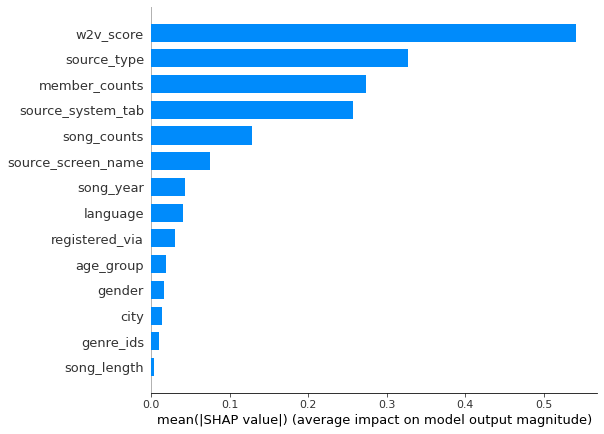

In [116]:
import shap

shap_values = shap.TreeExplainer(model).shap_values(dataset_train)

shap.summary_plot(shap_values, dataset_train, plot_type="bar")

Как и ожидали - получили w2v_score как самый влияющий на результат признак
